In [1]:
!pip install torchinfo
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 15.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import OxfordIIITPet
from torchvision.transforms import ToTensor, Resize
import torch.nn as N
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(42)

batch_size = 32
epochs = 5
learning_rate = 1e-3

filters = [32, 64, 128, 256]
drop_rate= 0.15

img_depth = 3

In [4]:
transforms = [ToTensor(), Resize((256,256))]

In [5]:
class CustomTransform(object):
    def __init__(self, transforms):
        super(CustomTransform, self).__init__()
        self.transforms = transforms
    def __call__(self, input):
        for transform in self.transforms:
            input = transform(input)
        return input

In [6]:
training_data = OxfordIIITPet('../content', 'trainval', 'segmentation', transform= CustomTransform(transforms), target_transform= CustomTransform(transforms), download= True)
test_data = OxfordIIITPet('../content', 'test', 'segmentation', transform= CustomTransform(transforms), target_transform= CustomTransform(transforms), download= False)

100%|██████████| 791918971/791918971 [00:20<00:00, 39389150.31it/s]


Extracting ../content/oxford-iiit-pet/images.tar.gz to ../content/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 18400825.78it/s]


Extracting ../content/oxford-iiit-pet/annotations.tar.gz to ../content/oxford-iiit-pet


In [7]:
train_dataloader = DataLoader(training_data, batch_size= batch_size, shuffle= True, drop_last= True)
test_dataloader = DataLoader(test_data, batch_size= batch_size, shuffle= True, drop_last= True)

In [8]:
import itertools

sample_index =  torch.randint(0, len(test_dataloader), size= (1,))
sample_input, sample_target = next(itertools.islice(test_dataloader, sample_index, None))

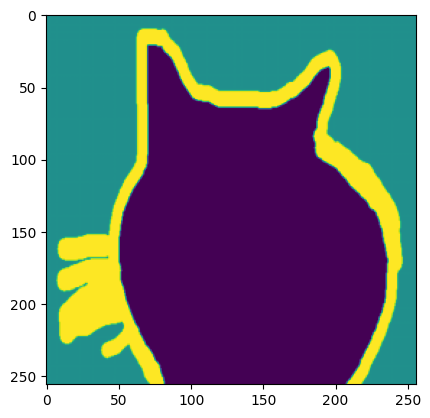

In [9]:
plt.imshow(sample_target[0].permute(1,2,0))

In [8]:
class DownwardBlock(N.Module):
    def __init__(self, in_channels, out_channels, device, stride= 1, kernel_size= 3, padding= 'same'):
        super(DownwardBlock, self).__init__()

        self.enc_block = N.Sequential(
            N.Conv2d(in_channels, out_channels, kernel_size, stride, padding, device= device, bias= False),
            N.BatchNorm2d(out_channels, device= device),
            N.ReLU(inplace= True),

            N.Conv2d(out_channels, out_channels, kernel_size, stride, padding, device= device, bias= False),
            N.BatchNorm2d(out_channels, device= device),
            N.ReLU(inplace= True)
        )

    def forward(self, input):
        output = self.enc_block(input)
        return output

In [9]:
class DownwardHalf(N.Module):
    def __init__(self, filters, device):
        super(DownwardHalf, self).__init__()
        self.down_blocks = N.ModuleList()
        self.mpool = N.MaxPool2d(kernel_size= 2, stride= 2)

        for i in range(len(filters)):
            if i == 0:
                self.down_blocks.append(DownwardBlock(3, filters[i], device= device))
            else:
                self.down_blocks.append(DownwardBlock(filters[i-1], filters[i], device= device))

    def forward(self, input):
        skip_conn = []
        for i in range(len(self.down_blocks)):
            input = self.down_blocks[i](input)
            skip_conn.append(input)
            input = self.mpool(input)

        return input, skip_conn

In [10]:
class UpwardBlock(N.Module):
    def __init__(self, in_channels, out_channels, device, stride= 1, kernel_size= 3, padding='same'):
        super(UpwardBlock, self).__init__()

        self.tconv = N.ConvTranspose2d(in_channels, out_channels, kernel_size= 2, stride= 2, device= device)
        self.dec_block = N.Sequential(
            N.Conv2d(in_channels, out_channels, kernel_size, stride, padding, device= device, bias= False),
            N.BatchNorm2d(out_channels, device= device),
            N.ReLU(inplace= True),

            N.Conv2d(out_channels, out_channels, kernel_size, stride, padding, device= device, bias= False),
            N.BatchNorm2d(out_channels, device= device),
            N.ReLU(inplace= True)
        )

    def forward(self, input, skip_conn):
        tconv_output = self.tconv(input)
        concat_output = torch.cat([tconv_output, skip_conn], dim= 1)
        output = self.dec_block(concat_output)

        return output

In [11]:
class UpwardHalf(N.Module):
    def __init__(self, filters, device):
        super(UpwardHalf, self).__init__()
        self.up_blocks = N.ModuleList()
        n = len(filters)

        for i in range(n):
          self.up_blocks.append(UpwardBlock(filters[n-i-1] * 2, filters[n-i-1], device))

    def forward(self, input, skip_conn):
        n = len(self.up_blocks)
        for i in range(n):
            input = self.up_blocks[i](input, skip_conn[n-i-1])

        return input

In [12]:
class UNet(N.Module):
    def __init__(self, filters, device):
        super(UNet, self).__init__()
        self.down_half = DownwardHalf(filters, device)
        self.up_half = UpwardHalf(filters, device)
        self.final_conv = N.Conv2d(filters[0], 1, 3, 1, 'same', device= device)
        self.bridge_block = N.Sequential(
            N.Conv2d(filters[-1], filters[-1] * 2, 3, 1, 'same', device= device, bias= False),
            N.BatchNorm2d(filters[-1] * 2, device= device),
            N.ReLU(inplace= True),

            N.Conv2d(filters[-1] * 2, filters[-1] * 2, 3, 1, 'same', device= device, bias= False),
            N.BatchNorm2d(filters[-1] * 2, device= device),
            N.ReLU(inplace= True)
        )

    def forward(self, input):
        down_half_output, skip_conn = self.down_half(input)
        bridge_block_output = self.bridge_block(down_half_output)
        up_half_output = self.up_half(bridge_block_output, skip_conn)
        output = self.final_conv(up_half_output)

        return output

In [13]:
from torchinfo import summary


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(filters, device)

summary(model, input_size= (batch_size, 3, 256, 256), col_names=['input_size', 'output_size', 'num_params', 'trainable'],

        row_settings=['var_names'], verbose=0)

Layer (type (var_name))                       Input Shape               Output Shape              Param #                   Trainable
UNet (UNet)                                   [32, 3, 256, 256]         [32, 1, 256, 256]         --                        True
├─DownwardHalf (down_half)                    [32, 3, 256, 256]         [32, 256, 16, 16]         --                        True
│    └─ModuleList (down_blocks)               --                        --                        (recursive)               True
│    │    └─DownwardBlock (0)                 [32, 3, 256, 256]         [32, 32, 256, 256]        10,208                    True
│    └─MaxPool2d (mpool)                      [32, 32, 256, 256]        [32, 32, 128, 128]        --                        --
│    └─ModuleList (down_blocks)               --                        --                        (recursive)               True
│    │    └─DownwardBlock (1)                 [32, 32, 128, 128]        [32, 64, 128, 128]    

In [14]:
from torchmetrics.segmentation import MeanIoU, GeneralizedDiceScore

loss_fn = N.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), learning_rate)
IoU = MeanIoU(3)
DiceScore = GeneralizedDiceScore(3)

In [15]:
for _ in range(epochs):
    train_loss = 0
    print(f"\nStarting epoch {_ + 1}\n~~~~~~~~~~~~~~")

    for index, (input, target) in enumerate(train_dataloader):
        input, target = input.cuda(), target.cuda()
        model.train()
        output = model(input)

        loss = loss_fn(output, target)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if(index % 100 == 0):
            print(f"Batch: {index} Loss:{loss:0.9f}")

        train_loss /= len(train_dataloader)
    test_loss, test_dice = 0, 0
    model.eval()

    with torch.inference_mode():
        for test_input, test_target in test_dataloader:
            test_input, test_target = test_input.cuda(), test_target.cuda()

            test_pred = model(test_input)
            test_loss += loss_fn(test_pred, test_target)
            # test_dice += DiceScore(test_target, test_pred)

        test_loss /= len(test_dataloader)
        test_dice /= len(test_dataloader)

    print(f"Train loss: {train_loss:0.5f} Test loss: {test_loss:0.5f} Test dice score: {test_dice:0.2f}")


Starting epoch 1
~~~~~~~~~~~~~~
Batch: 0 Loss:-0.000000000
Batch: 100 Loss:-0.000000000


KeyboardInterrupt: 